## Random Forest Model & Hyperparameter Tuning

In this notebook, we build, train, and tune by [__GridSearchCV__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) a [__Random_Forest Classifier__](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to predict the __Outcome Type__ field of our review dataset.


1. <a href="#1">Read the dataset</a>
2. <a href="#2">Exploratory Data Analysis</a>
3. <a href="#3">Select features to build the model</a>
4. <a href="#4">Training, validation and test datasets</a>
5. <a href="#5">Data processing with Pipeline and ColumnTransformer</a>
6. <a href="#6">Train and tune a classifier</a>
7. <a href="#7">Test the classifier</a>
8. <a href="#8">Improvement ideas</a>

__Austin Animal Center Dataset__:

In this exercise, we are working with pet adoption data from __Austin Animal Center__. We have two datasets that cover intake and outcome of animals. Intake data is available from [here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm) and outcome is from [here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238). 

In order to work with a single table, we joined the intake and outcome tables using the "Animal ID" column and created a single __review.csv__ file. We also didn't consider animals with multiple entries to the facility to keep our dataset simple. If you want to see the original datasets and the merged data with multiple entries, they are available under `DATA/review` folder: Austin_Animal_Center_Intakes.csv, Austin_Animal_Center_Outcomes.csv and Austin_Animal_Center_Intakes_Outcomes.csv.

__Dataset schema:__ 
- __Pet ID__ - Unique ID of pet
- __Outcome Type__ - State of pet at the time of recording the outcome (0 = not placed, 1 = placed). This is the field to predict.
- __Sex upon Outcome__ - Sex of pet at outcome
- __Name__ - Name of pet 
- __Found Location__ - Found location of pet before entered the center
- __Intake Type__ - Circumstances bringing the pet to the center
- __Intake Condition__ - Health condition of pet when entered the center
- __Pet Type__ - Type of pet
- __Sex upon Intake__ - Sex of pet when entered the center
- __Breed__ - Breed of pet 
- __Color__ - Color of pet 
- __Age upon Intake Days__ - Age of pet when entered the center (days)
- __Age upon Outcome Days__ - Age of pet at outcome (days)


In [1]:
# #Upgrade dependencies
# !pip install --upgrade pip
# !pip install --upgrade scikit-learn

## 1. <a name="1">Read the dataset</a>
(<a href="#0">Go to top</a>)

Let's read the dataset into a dataframe, using Pandas.

In [2]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
  
df = pd.read_csv('../../DATA/review/review_dataset.csv')

print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (95485, 13)


## 2. <a name="2">Exploratory Data Analysis</a>
(<a href="#0">Go to top</a>)

We will look at number of rows, columns and some simple statistics of the dataset.

In [3]:
# Print the first five rows
# NaN means missing data
df.head()

Pet ID  Outcome Type Sex upon Outcome        Name  \
0  A794011           1.0    Neutered Male       Chunk   
1  A776359           1.0    Neutered Male       Gizmo   
2  A674754           0.0      Intact Male         NaN   
3  A689724           1.0    Neutered Male  *Donatello   
4  A680969           1.0    Neutered Male       *Zeus   

                        Found Location      Intake Type Intake Condition  \
0                          Austin (TX)  Owner Surrender           Normal   
1    7201 Levander Loop in Austin (TX)            Stray           Normal   
2        12034 Research in Austin (TX)            Stray          Nursing   
3     2300 Waterway Bnd in Austin (TX)            Stray           Normal   
4  4701 Staggerbrush Rd in Austin (TX)            Stray          Nursing   

  Pet Type Sex upon Intake                    Breed               Color  \
0      Cat   Neutered Male   Domestic Shorthair Mix   Brown Tabby/White   
1      Dog     Intact Male  Chihuahua Shorthair Mix         White/Brown   
2      Cat     Intact Male   Domestic Shorthair Mix        Orange Tabby   
3      Cat     Intact Male   Domestic Shorthair Mix               Black   
4      Cat     Intact Male   Domestic Shorthair Mix  White/Orange Tabby   

   Age upon Intake Days  Age upon Outcome Days  
0                   730                    730  
1                   365                    365  
2                     6                      6  
3                    60                     60  
4                     7                     60

In [4]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95485 entries, 0 to 95484
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Pet ID                 95485 non-null  object 
 1   Outcome Type           95485 non-null  float64
 2   Sex upon Outcome       95484 non-null  object 
 3   Name                   59138 non-null  object 
 4   Found Location         95485 non-null  object 
 5   Intake Type            95485 non-null  object 
 6   Intake Condition       95485 non-null  object 
 7   Pet Type               95485 non-null  object 
 8   Sex upon Intake        95484 non-null  object 
 9   Breed                  95485 non-null  object 
 10  Color                  95485 non-null  object 
 11  Age upon Intake Days   95485 non-null  int64  
 12  Age upon Outcome Days  95485 non-null  int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 9.5+ MB


In [5]:
# This prints basic statistics for numerical columns
df.describe()

Outcome Type  Age upon Intake Days  Age upon Outcome Days
count  95485.000000          95485.000000           95485.000000
mean       0.564005            703.436959             717.757313
std        0.495889           1052.252197            1055.023160
min        0.000000              0.000000               0.000000
25%        0.000000             30.000000              60.000000
50%        1.000000            365.000000             365.000000
75%        1.000000            730.000000             730.000000
max        1.000000           9125.000000            9125.000000

Let's separate model features and model target. 

In [6]:
print(df.columns)

Index(['Pet ID', 'Outcome Type', 'Sex upon Outcome', 'Name', 'Found Location',
       'Intake Type', 'Intake Condition', 'Pet Type', 'Sex upon Intake',
       'Breed', 'Color', 'Age upon Intake Days', 'Age upon Outcome Days'],
      dtype='object')


In [7]:
model_features = df.columns.drop('Outcome Type')
model_target = 'Outcome Type'

print('Model features: ', model_features)
print('Model target: ', model_target)

Model features:  Index(['Pet ID', 'Sex upon Outcome', 'Name', 'Found Location', 'Intake Type',
       'Intake Condition', 'Pet Type', 'Sex upon Intake', 'Breed', 'Color',
       'Age upon Intake Days', 'Age upon Outcome Days'],
      dtype='object')
Model target:  Outcome Type


We can explore the features set further, figuring out first what features are numerical or categorical. Beware that some integer-valued features could actually be categorical features, and some categorical features could be text features. 

In [8]:
import numpy as np
numerical_features_all = df[model_features].select_dtypes(include=np.number).columns
print('Numerical columns:',numerical_features_all)

print('')

categorical_features_all = df[model_features].select_dtypes(include='object').columns
print('Categorical columns:',categorical_features_all)


Numerical columns: Index(['Age upon Intake Days', 'Age upon Outcome Days'], dtype='object')

Categorical columns: Index(['Pet ID', 'Sex upon Outcome', 'Name', 'Found Location', 'Intake Type',
       'Intake Condition', 'Pet Type', 'Sex upon Intake', 'Breed', 'Color'],
      dtype='object')


#### Target distribution

Let's check our target distribution.

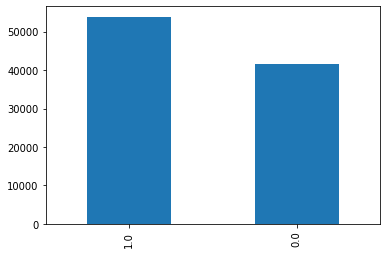

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

df[model_target].value_counts().plot.bar()
plt.show()

From the target plots we can identify whether or not we are dealing with imbalanced datasets - this means one result type is dominating the other one(s). 

Handling class imbalance is highly recommended, as the model performance can be greatly impacted. In particular the model may not work well for the infrequent classes, as there are not enough samples to learn patterns from, and so it would be hard for the classifier to identify and match those patterns. 

We might want to downsample the dominant class or upsample the rare the class, to help with learning its patterns. However, we should only fix the imbalance in training set, without changing the validation and test sets, as these should follow the original distribution. We will perform this task after train/test split. 


## 3. <a name="3">Select features to build the model</a>
(<a href="#0">Go to top</a>)

This time we build a model using all features. That is, we build a classifier including __numerical, categorical__ and __text__ features. 

In [10]:
# Grab model features/inputs and target/output

# can also grab less numerical features, as some numerical data might not be very useful
numerical_features = ['Age upon Intake Days', 'Age upon Outcome Days']

# dropping the IDs features, RescuerID and PetID here 
categorical_features = ['Sex upon Outcome', 'Intake Type',
       'Intake Condition', 'Pet Type', 'Sex upon Intake']

# from EDA, select the text features
text_features = ['Name', 'Found Location', 'Breed', 'Color']
    
model_features = numerical_features + categorical_features + text_features
model_target = 'Outcome Type'

#### Cleaning numerical features 

Age upon Intake Days


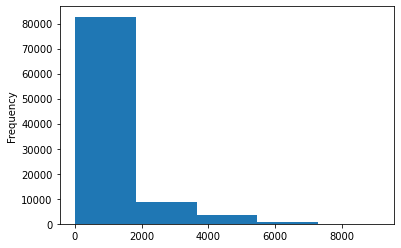

Age upon Outcome Days


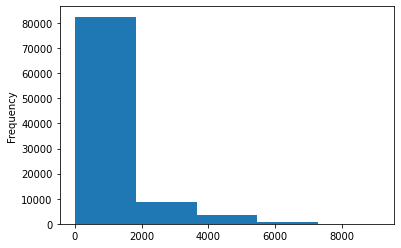

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

for c in numerical_features:
    print(c)
    df[c].plot.hist(bins=5)
    plt.show()

If for some histograms the values are heavily placed in the first bin, it is good to check for outliers, either checking the min-max values of those particular features and/or explore value ranges.

In [12]:
for c in numerical_features:
    print(c)
    print('min:', df[c].min(), 'max:', df[c].max())

Age upon Intake Days
min: 0 max: 9125
Age upon Outcome Days
min: 0 max: 9125


With __value_counts()__ function, we can increase the number of histogram bins to 10 for more bins for a more refined view of the numerical features.

In [13]:
for c in numerical_features: 
    print(c)
    print(df[c].value_counts(bins=10, sort=False))
    print('\n')
    plt.show()

Age upon Intake Days
(-9.126, 912.5]     74835
(912.5, 1825.0]     10647
(1825.0, 2737.5]     3471
(2737.5, 3650.0]     3998
(3650.0, 4562.5]     1234
(4562.5, 5475.0]     1031
(5475.0, 6387.5]      183
(6387.5, 7300.0]       79
(7300.0, 8212.5]        5
(8212.5, 9125.0]        2
Name: Age upon Intake Days, dtype: int64


Age upon Outcome Days
(-9.126, 912.5]     74642
(912.5, 1825.0]     10699
(1825.0, 2737.5]     3465
(2737.5, 3650.0]     4080
(3650.0, 4562.5]     1263
(4562.5, 5475.0]     1061
(5475.0, 6387.5]      187
(6387.5, 7300.0]       81
(7300.0, 8212.5]        5
(8212.5, 9125.0]        2
Name: Age upon Outcome Days, dtype: int64




If any outliers are identified as very likely wrong values, dropping them could improve the numerical values histograms, and later overall model performance. While a good rule of thumb is that anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier, other rules for removing 'outliers' should be considered as well. 

Let's check missing values for these numerical features.

In [14]:
print(df[numerical_features].isna().sum())

Age upon Intake Days     0
Age upon Outcome Days    0
dtype: int64


If any missing values, as a quick fix, we can apply mean imputation. This will replace the missing values with the mean value of the corresponding column.

__Note__: The statistically correct way to perform mean/mode imputation before training an ML model is to compute the column-wise means on the training data only, and then use these values to impute missing data in both the train and test sets. So, you'll need to split your dataset first. Same goes for any other transformations we would like to apply to these numerical features, such as scaling. 


#### Cleaning categorical features 

Let's also examine the categorical features.

In [15]:
for c in categorical_features:
    print(c)
    print(df[c].unique()) #value_counts())

Sex upon Outcome
['Neutered Male' 'Intact Male' 'Intact Female' 'Unknown' 'Spayed Female'
 nan]
Intake Type
['Owner Surrender' 'Stray' 'Wildlife' 'Public Assist' 'Euthanasia Request'
 'Abandoned']
Intake Condition
['Normal' 'Nursing' 'Sick' 'Injured' 'Aged' 'Feral' 'Pregnant' 'Other'
 'Behavior' 'Medical']
Pet Type
['Cat' 'Dog' 'Other' 'Bird' 'Livestock']
Sex upon Intake
['Neutered Male' 'Intact Male' 'Intact Female' 'Unknown' 'Spayed Female'
 nan]


__Note on boolean type features__: Some categories might be of boolean type, like __False__ and __True__. The booleans will raise errors when trying to encode the categoricals with sklearn encoders, none of which accept boolean types. If using pandas get_dummies to one-hot encode the categoricals, there's no need to convert the booleans. However, get_dummies is trickier to use with sklearn's Pipeline and GridSearch. 

One way to deal with the booleans is to convert them to strings, by using a mask and a map changing only the booleans. Another way to handle the booleans is to convert them to strings by changing the type of all categoricals to 'str'. This will also affect the nans, basically performing imputation of the nans with a 'nans' placeholder value! 

Applying the type conversion to both categoricals and text features, takes care of the nans in the text fields as well. In case other imputations are planned for the categoricals and/or test fields, notice that the masking shown above leaves the nans unchanged.

In [16]:
df[categorical_features + text_features] = df[categorical_features + text_features].astype('str')

Let's have a check on missing values for the categorical features (and text features here).

In [17]:
print(df[categorical_features + text_features].isna().sum())

Sex upon Outcome    0
Intake Type         0
Intake Condition    0
Pet Type            0
Sex upon Intake     0
Name                0
Found Location      0
Breed               0
Color               0
dtype: int64


Converting categoricals into useful numerical features will also have to wait until after the train/test split.

#### Cleaning text features 

Also a good idea to look at the text fields. Text cleaning can be performed here, before train/test split, with less code. 

In [18]:
for c in text_features:
    print(c)
    print(df[c].unique()[:10]) 
    print('\n')

Name
['Chunk' 'Gizmo' 'nan' '*Donatello' '*Zeus' 'Artemis' '*Birch' '*Liza'
 'Star' 'Millie']


Found Location
['Austin (TX)' '7201 Levander Loop in Austin (TX)'
 '12034 Research in Austin (TX)' '2300 Waterway Bnd in Austin (TX)'
 '4701 Staggerbrush Rd in Austin (TX)'
 '10015 Lake Creek Pkwy in Austin (TX)' '9200 N Plaza Dr in Austin (TX)'
 'Hill Croft Drive & Loyola Lane in Austin (TX)'
 '2607 Garrettson Drive in Austin (TX)'
 '8711 Johnny Morris in Austin (TX)']


Breed
['Domestic Shorthair Mix' 'Chihuahua Shorthair Mix' 'Domestic Shorthair'
 'Opossum' 'Yorkshire Terrier Mix'
 'Jack Russell Terrier/Chihuahua Shorthair' 'Great Pyrenees Mix' 'Bat Mix'
 'Australian Cattle Dog Mix' 'Labrador Retriever Mix']


Color
['Brown Tabby/White' 'White/Brown' 'Orange Tabby' 'Black'
 'White/Orange Tabby' 'Blue/White' 'Brown Tabby' 'Gray' 'Calico'
 'Brown/Black']




We re-use the helper functions from the 'Text processing' notebook above.

__Warning__: cleaning stage can take a few minutes, depending on how much text is there to process.

In [19]:
# Prepare cleaning functions
import re, string
import nltk
from nltk.stem import SnowballStemmer

stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

stemmer = SnowballStemmer('english')

def preProcessText(text):
    # lowercase and strip leading/trailing white space
    text = text.lower().strip()
    
    # remove HTML tags
    text = re.compile('<.*?>').sub('', text)
    
    # remove punctuation
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    
    # remove extra white space
    text = re.sub('\s+', ' ', text)
    
    return text

def lexiconProcess(text, stop_words, stemmer):
    filtered_sentence = []
    words = text.split(" ")
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(stemmer.stem(w))
    text = " ".join(filtered_sentence)
    
    return text

def cleanSentence(text, stop_words, stemmer):
    return lexiconProcess(preProcessText(text), stop_words, stemmer)

# Clean the text features
for c in text_features:
    print('Text cleaning: ', c)
    df[c] = [cleanSentence(item, stop_words, stemmer) for item in df[c].values]

Text cleaning:  Name
Text cleaning:  Found Location
Text cleaning:  Breed
Text cleaning:  Color


The cleaned text features are ready to be vectorized after the train/test split.

__Note__: more exploratory data analysis might reveal other important hidden atributes and/or relationships of the model features considered. 

## 4. <a name="4">Training, validation and test datasets</a>
(<a href="#0">Go to top</a>)

We split our dataset into training (90%) and test (10%) subsets using sklearn's [__train_test_split()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [20]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.1, shuffle=True, random_state=23)
train_data, val_data = train_test_split(train_data, test_size=0.15, shuffle=True, random_state=23)


#### Target balancing

In [21]:
print('Training set shape:', train_data.shape)

print('Class 0 samples in the training set:', sum(train_data[model_target] == 0))
print('Class 1 samples in the training set:', sum(train_data[model_target] == 1))

print('Class 0 samples in the test set:', sum(test_data[model_target] == 0))
print('Class 1 samples in the test set:', sum(test_data[model_target] == 1))

Training set shape: (73045, 13)
Class 0 samples in the training set: 31844
Class 1 samples in the training set: 41201
Class 0 samples in the test set: 4132
Class 1 samples in the test set: 5417


__Important note:__ We want to fix the imbalance only in training set. We shouldn't change the validation and test sets, as these should follow the original distribution.

In [22]:
from sklearn.utils import shuffle

class_0_no = train_data[train_data[model_target] == 0]
class_1_no = train_data[train_data[model_target] == 1]

upsampled_class_0_no = class_0_no.sample(n=len(class_1_no), replace=True, random_state=42)

train_data = pd.concat([class_1_no, upsampled_class_0_no])
train_data = shuffle(train_data)

In [23]:
print('Training set shape:', train_data.shape)

print('Class 1 samples in the training set:', sum(train_data[model_target] == 1))
print('Class 0 samples in the training set:', sum(train_data[model_target] == 0))

Training set shape: (82402, 13)
Class 1 samples in the training set: 41201
Class 0 samples in the training set: 41201


## 5. <a name="5">Data processing with Pipeline and ColumnTransformer</a>
(<a href="#0">Go to top</a>)

Let's build a more complex pipeline today. We first build separate pipelines to handle the numerical, categorical, and text features, and then combine them into a composite pipeline along with an estimator, a [Random_Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) here.

   * For the numerical features pipeline, the __numerical_processor__ below, we impute missing values with the mean using sklearn's SimpleImputer, followed by a MinMaxScaler (don't have to scale features when using tree-based algorithms, but it's a good idea to see how to use more data transforms). If different processing is desired for different numerical features, different pipelines should be built - just like shown below for the two text features.
   
   
   * In the categoricals pipeline, the __categorical_processor__ below, we impute with a placeholder value (no effect here as we already encoded the 'nan's), and encode with sklearn's OneHotEncoder. If computing memory is an issue, it is a good idea to check categoricals' unique values, to get an estimate of many dummy features will be created by one-hot encoding. Note the __handle_unknown__ parameter that tells the encoder to ignore (rather than throw an error for) any unique value that might show in the validation/and or test set that was not present in the initial training set.
  
   
   * And, finally, also with memory usage in mind, we build two more pipelines, one for each of our text features, trying different vocabulary sizes.
   
The selective preparations of the dataset features are then put together into a collective __ColumnTransformer__, to be finally used in a __Pipeline__ along with an estimator. This ensures that the transforms are performed automatically on the raw data when fitting the model and when making predictions, such as when evaluating the model on a validation dataset via cross-validation or making predictions on a test dataset in the future.

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline([
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('num_scaler', MinMaxScaler()) # Shown in case is needed, not a must with Trees
                                ])
                  
# Preprocess the categorical features
categorical_processor = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')), # Shown in case is needed, no effect here as we already imputed with 'nan' strings
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore')) # handle_unknown tells it to ignore (rather than throw an error for) any value that was not present in the initial training set.
                                ])

# Preprocess 1st text feature
text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(binary=True, max_features=50))
                                ])

# Preprocess 2nd text feature (larger vocabulary)
text_precessor_1 = Pipeline([
    ('text_vect_1', CountVectorizer(binary=True, max_features=150))
                                ])

# Combine all data preprocessors from above (add more, if you choose to define more!)
# For each processor/step specify: a name, the actual process, and finally the features to be processed
data_preprocessor = ColumnTransformer([
    ('numerical_pre', numerical_processor, numerical_features),
    ('categorical_pre', categorical_processor, categorical_features),
    ('text_pre_0', text_processor_0, text_features[0]),
    ('text_pre_1', text_precessor_1, text_features[1])
                                    ]) 

### PIPELINE ###
################

# Pipeline desired all data transformers, along with an estimator at the end
# Later you can set/reach the parameters using the names issued - for hyperparameter tuning, for example
pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('rf', RandomForestClassifier())
                    ])

# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config
set_config(display='diagram')
pipeline

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age upon Intake Days',
                                                   'Age upon Outcome Days']),
                                                 ('categorical_pre',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex upon Outcome',
                                                   'Intake Type',
                                                   'Intake Condition',
                                                   'Pet Type',
                                                   'Sex upon Intake']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'Name'),
                                                 ('text_pre_1',
                                                  Pipeline(steps=[('text_vect_1',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'Found Location')])),
                ('rf', RandomForestClassifier())])

## 6. <a name="6">Train and tune a classifier</a>
(<a href="#0">Go to top</a>)

Let's first train and test the above composite pipeline on the train and the test sets.  

In [27]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get train data to train the pipeline
X_train = train_data[model_features]
y_train = train_data[model_target]

# Fit the Pipeline to training data
pipeline.fit(X_train, y_train)

# Use the fitted pipeline to make predictions on the train dataset
train_predictions = pipeline.predict(X_train)
print(confusion_matrix(y_train, train_predictions))
print(classification_report(y_train, train_predictions))
print("Accuracy (training):", accuracy_score(y_train, train_predictions))

[[38603  2598]
 [ 1321 39880]]
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95     41201
         1.0       0.94      0.97      0.95     41201

    accuracy                           0.95     82402
   macro avg       0.95      0.95      0.95     82402
weighted avg       0.95      0.95      0.95     82402

Accuracy (training): 0.9524404747457585


In [28]:
# Get validation data to test the pipeline
X_val = val_data[model_features]
y_val = val_data[model_target]

# Use the fitted pipeline to make predictions on the test dataset
val_predictions = pipeline.predict(X_val)
print(confusion_matrix(y_val, val_predictions))
print(classification_report(y_val, val_predictions))
print("Accuracy (test):", accuracy_score(y_val, val_predictions))

[[4267 1388]
 [ 807 6429]]
              precision    recall  f1-score   support

         0.0       0.84      0.75      0.80      5655
         1.0       0.82      0.89      0.85      7236

    accuracy                           0.83     12891
   macro avg       0.83      0.82      0.82     12891
weighted avg       0.83      0.83      0.83     12891

Accuracy (test): 0.8297261655418509


#### Hyperparameter Tuning

We next use sklearn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to look for hyperparameter combinations to improve the accuracy on the test set (and reduce the generalization gap). As GridSearchCV does cross-validation train-validation split internally, 
our data transformers inside the Pipeline context will force the correct behavior of learning data transformations on the training set, and applying the transformations to the validation set when cross-validating, as well as on the test set later when running test predictions.

Also, Pipeline's steps names give easy access to hyperparameters for hyperparameter tuning while cross-validating. Parameters of the estimators in the pipeline can be accessed using the __estimator__ __ __parameter__ syntax. Note the __double underscores__ connecting the __estimator__ and __parameter__!

In [29]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### PIPELINE GRID_SEARCH ###
############################

# Parameter grid for GridSearch
param_grid={'rf__n_estimators': [20],#, 100, 200, 300], 
            'rf__max_depth': [100, 200, 300],#, 50, 75, 100, 125, 150, 200, 250], 
            'rf__min_samples_leaf': [5, 10, 15],#, 25, 30],
            'rf__min_samples_split': [2, 5, 15]#, 25, 30, 45, 50]
           }

grid_search = GridSearchCV(pipeline, # Base model
                           param_grid, # Parameters to try
                           cv = 5, # Apply 5-fold cross validation
                           verbose = 1, # Print summary
                           n_jobs = -1 # Use all available processors
                          )

# Fit the GridSearch to our training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('data_preprocessing',
                                        ColumnTransformer(transformers=[('numerical_pre',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('num_scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Age '
                                                                          'upon '
                                                                          'Intake '
                                                                          'Days',
                                                                          'Age '
                                                                          'upon '
                                                                          'Outcome '
                                                                          'Days']),
                                                                        ('categorical_pre',
                                                                         Pipeline(steps=[('cat_imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='cons...
                                                                                          CountVectorizer(binary=True,
                                                                                                          max_features=50))]),
                                                                         'Name'),
                                                                        ('text_pre_1',
                                                                         Pipeline(steps=[('text_vect_1',
                                                                                          CountVectorizer(binary=True,
                                                                                                          max_features=150))]),
                                                                         'Found '
                                                                         'Location')])),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [100, 200, 300],
                         'rf__min_samples_leaf': [5, 10, 15],
                         'rf__min_samples_split': [2, 5, 15],
                         'rf__n_estimators': [20]},
             verbose=1)

In [30]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'rf__max_depth': 100, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 20}
0.8443484575942997


In [31]:
# Get the best model out of GridSearchCV
classifier = grid_search.best_estimator_

# Fit the best model to the train data once more
classifier.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age upon Intake Days',
                                                   'Age upon Outcome Days']),
                                                 ('categorical_pre',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(han...
                                                   'Intake Type',
                                                   'Intake Condition',
                                                   'Pet Type',
                                                   'Sex upon Intake']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'Name'),
                                                 ('text_pre_1',
                                                  Pipeline(steps=[('text_vect_1',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'Found Location')])),
                ('rf',
                 RandomForestClassifier(max_depth=100, min_samples_leaf=5,
                                        n_estimators=20))])

## 7. <a name="7">Test the classifier</a>
(<a href="#0">Go to top</a>)

Now we test the best model with the best parameters on "unseen" data (our test data).

Before that, let's first see how the model works on the training dataset.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Use the fitted model to make predictions on the train dataset
train_predictions = classifier.predict(X_train)

print('Model performance on the train set:')
print(confusion_matrix(y_train, train_predictions))
print(classification_report(y_train, train_predictions))
print("Train accuracy:", accuracy_score(y_train, train_predictions))    

And now, let's evaluate the performance of the classifier on the test set.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get test data to test the classifier
X_test = test_data[model_features]
y_test = test_data[model_target]

# Use the fitted model to make predictions on the test dataset
# Test data going through the Pipeline it's first imputed (with means from the train), scaled (with the min/max from the train data), and finally used to make predictions
test_predictions = classifier.predict(X_test)

print('Model performance on the test set:')
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))
print("Test accuracy:", accuracy_score(y_test, test_predictions))